# Data Leakage (Shooting yourself in the foot)

In [8]:
import pandas as pd

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy

In [3]:
k, N = 5_000, 500

In [4]:
X = numpy.random.rand(k*N).reshape(N, k)
y = numpy.random.choice([0, 1], N)

In [5]:
from sklearn.feature_selection import SelectKBest

In [6]:
Xp = SelectKBest(k=10).fit_transform(X, y)

In [7]:
import seaborn

In [9]:
from sklearn.model_selection import cross_val_score

<AxesSubplot:ylabel='Frequency'>

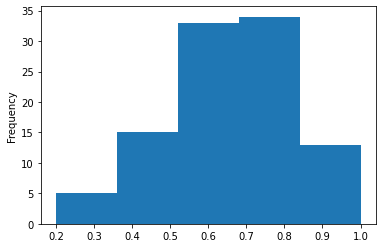

In [15]:
pd.Series(cross_val_score(LogisticRegression(), Xp, y, cv=100)).plot.hist(bins=5)

## The correct way

In [16]:
from sklearn.pipeline import Pipeline

In [18]:
model = Pipeline(steps=[
    ('feature_select', SelectKBest(k=10)),
    ('model', LogisticRegression())])

<AxesSubplot:ylabel='Frequency'>

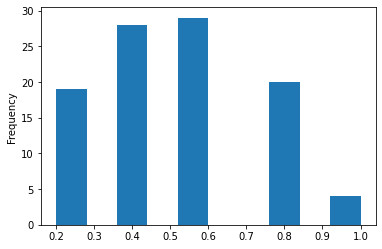

In [19]:
pd.Series(cross_val_score(model, X, y, cv=100)).plot.hist()

# Reproducibility

In [20]:
df = pd.read_csv("data/income_data.csv")

In [21]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [22]:
cat_cols = ['sex', 'education', 'race']
cont_cols = ['age', 'hours-per-week']
features = cat_cols + cont_cols
target = 'target'

## Everything goes into a Pipeline

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [24]:
cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', min_frequency=0.05,
                             handle_unknown='infrequent_if_exist'))])
cont_trans = Pipeline(steps=[('scaler', StandardScaler())])
feat_trans = ColumnTransformer(transformers=[
    ('categorical', cat_trans, cat_cols),
    ('continuous', cont_trans, cont_cols)])

In [25]:
def mk_tree(depth):
    return Pipeline(steps=[
        ('trans', feat_trans),
        ('classifier', DecisionTreeClassifier(max_depth=depth))])

In [26]:
mk_tree(3)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

## Model evaluation

In [27]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [28]:
Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3)

In [30]:
sklearn.metrics.accuracy_score(yte, mk_tree(5).fit(Xtr, ytr).predict(Xte))

0.7876957723410789

In [31]:
def mk_score(depth):
    Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3)
    return sklearn.metrics.accuracy_score(yte, mk_tree(depth).fit(Xtr, ytr).predict(Xte))

<AxesSubplot:ylabel='Frequency'>

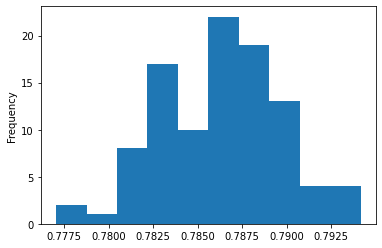

In [32]:
pd.Series([mk_score(5) for _ in range(100)]).plot.hist() # still not reproducible, just the data is the same!

In [34]:
def mk_score_improved(depth, seed):
    Xtr, Xte, ytr, yte = train_test_split(df[features], df[target], test_size=0.3, random_state=seed)
    return sklearn.metrics.accuracy_score(yte, mk_tree(depth).fit(Xtr, ytr).predict(Xte))

In [35]:
[mk_score_improved(5, 123) for _ in range(10)]

[0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244,
 0.7881052308322244]

In [36]:
[cross_val_score(mk_tree(3), df[features], df[target]) for _ in range(10)] # no randomness

[array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845]),
 array([0.76063258, 0.76136364, 0.76382064, 0.76581695, 0.76458845])]

## Random seeds for models

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
def mk_forest(depth):
    return Pipeline(steps=[
        ('trans', feat_trans),
        ('classifier', RandomForestClassifier(max_depth=depth))])

In [40]:
[cross_val_score(mk_forest(3), df[features], df[target]) for _ in range(2)] # randomness from random forest

[array([0.76600645, 0.76965602, 0.76842752, 0.76812039, 0.76765971]),
 array([0.76600645, 0.76965602, 0.76796683, 0.76796683, 0.76765971])]

In [42]:
def mk_forest_improved(depth, seed):
    return Pipeline(steps=[
        ('trans', feat_trans),
        ('classifier', RandomForestClassifier(max_depth=depth, random_state=seed))])

In [43]:
[cross_val_score(mk_forest_improved(3, 42), df[features], df[target]) for _ in range(2)] # no randomness from random forest

[array([0.76600645, 0.76965602, 0.76796683, 0.76796683, 0.76781327]),
 array([0.76600645, 0.76965602, 0.76796683, 0.76796683, 0.76781327])]

# Privacy: Randomization

In [44]:
values = numpy.random.choice([0, 1], 10_000)

In [45]:
values.mean()

0.5008

In [47]:
def randomize(a, theta):
    coins = numpy.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = numpy.random.choice([0, 1], size=a.shape)
    response = numpy.array(a)
    response[~coins] = noise[~coins]
    return response

In [48]:
randomize(values, 0.8)[:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [49]:
randomize(values, 0.8).mean()

0.5018

In [50]:
values = numpy.random.choice([0, 1], 10_000, p=(0.8, 0.2))

In [51]:
values.mean()

0.2028

In [52]:
randomize(values, 0.8).mean()

0.2607

In [53]:
# theta * p + (1-theta)*1/2
0.8 * 0.2 + (1-0.8)/2

0.26

## Use random mechanism in a model

In [54]:
from sklearn.preprocessing import FunctionTransformer

In [64]:
df['education'].isin([' Masters', ' Bachelors']) # whitespace issues

0         True
1         True
2        False
3        False
4         True
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Name: education, Length: 32561, dtype: bool

In [63]:
df['education'].isin([' Masters']).mean()

0.05291606523141181

In [65]:
df['education'].isin([' Masters', ' Bachelors'])*1

0        1
1        1
2        0
3        0
4        1
        ..
32556    0
32557    0
32558    0
32559    0
32560    0
Name: education, Length: 32561, dtype: int64

In [70]:
higher_ed = [' Masters', ' Bachelors', ' Doctorate', ' Prof-school']

def mk_randomized_pipeline(theta):
    return Pipeline(steps=[
        ('higher-ed', FunctionTransformer(lambda x: x.isin(higher_ed)*1)),
        ('randomize', FunctionTransformer(randomize, kw_args={'theta': theta}))
    ])

In [71]:
def feature_transform(theta):
    return ColumnTransformer(transformers=[
        ('randomize_ed', mk_randomized_pipeline(theta), ['education']),
        ('age-hours', FunctionTransformer(), ['age', 'hours-per-week'])])

def mk_model(theta, d):
    return Pipeline(steps=[
        ('feature_trans', feature_transform(theta)),
        ('classifier', DecisionTreeClassifier(max_depth=d))])

In [72]:
mk_model(0.3, 5).fit(df, df[target])

Pipeline(steps=[('feature_trans',
                 ColumnTransformer(transformers=[('randomize_ed',
                                                  Pipeline(steps=[('higher-ed',
                                                                   FunctionTransformer(func=<function mk_randomized_pipeline.<locals>.<lambda> at 0x29a04e5f0>)),
                                                                  ('randomize',
                                                                   FunctionTransformer(func=<function randomize at 0x299f65fc0>,
                                                                                       kw_args={'theta': 0.3}))]),
                                                  ['education']),
                                                 ('age-hours',
                                                  FunctionTransformer(),
                                                  ['age', 'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=5))])

In [73]:
cross_val_score(mk_model(0.3, 5), df, df[target])

array([0.76585291, 0.77042383, 0.77211302, 0.76612408, 0.76934889])

In [76]:
thetas = numpy.linspace(0.2, 1.0, 15)
scores = [cross_val_score(mk_model(theta, 5), df, df[target])
          for theta in thetas]

<AxesSubplot:>

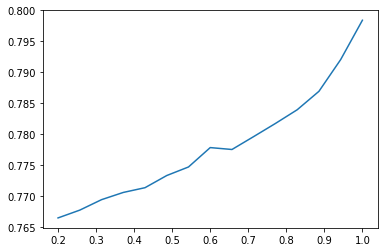

In [78]:
pd.Series([s.mean() for s in scores], index=thetas).plot.line()